# Optimization of Scientific Code with Cython: Ising Model

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/) on the blog [Pythonic Perambulations](http://jakevdp.github.io).*

<!-- PELICAN_BEGIN_SUMMARY -->

Python is quick and easy to code, but can be slow when doing intensive numerical operations. Translating code to Cython can be helpful, but in most cases requires a bit of trial and error to achieve the optimal result. [Cython's tutorials](http://cython.readthedocs.io/en/latest/src/tutorial/) contain a lot of information, but for iterative workflows like optimization with Cython, it's often useful to see it done "live".

For that reason, I decided to record some screencasts showing this iterative optimization process, using an  [Ising Model](https://en.wikipedia.org/wiki/Ising_model), as an example application.

<!-- PELICAN_END_SUMMARY -->

## When to use Cython

Before I get to the videos, I wanted to say a few words about *when* and *why* you might choose Cython.

With scientific Python code, before turning to Cython I'd suggest going as far as you can with *vectorization*.
Vectorization involves the judicious use of built-in routines in NumPy, SciPy, Pandas, and other libraries to reduce the number of explicit for-loops in your code. It can work quite well in many situations, and doesn't require any sort of special compilation step in running your code. See my PyCon 2015 talk, [Losing Your Loops](https://www.youtube.com/watch?v=EEUXKG97YRw) for an intro to this approach.

When a problem cannot be easily solved using standard vectorization approaches, Cython is a good choice.
Cython provides a bridge between Python and C code, and is quite mature and reliable: it forms the basis of much of the PyData/Scientific Python ecosystem (for example, Cython is used heavily in NumPy, SciPy, Pandas, Scikit-Learn, and many other packages).

Other approaches to optimizing Python code are available, but I tend not to use them as often as Cython:

The [PyPy](https://pypy.org/) project is an alternative implementation of Python that avoids the slow loops of the default CPython implementation. Although it is quite promising, it currently does not support many of the core scientific packages, so is not the best choice for scientific code (though that has been changing).

[Numba](http://numba.pydata.org/) is a Python-to-LLVM converter which can often give you 100x speedups in Python by adding a simple compilation decorator to Python functions. For an example of Numba being used on code like that in this notebook, see [Matthew Rocklin's post](http://matthewrocklin.com/blog/work/2015/02/28/Ising). Though it is convenient, Numba doesn't support all Python constructs yet, and can be difficult to optimize when the most straightforward approach fails.

## The Code

Below you can find the code that I wrote in those two videos:

### 1. Simple Python Ising Model

#### Displaying an Ising Field

In [8]:
import numpy as np

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

random_spin_field(10, 10)

array([[ 1, -1,  1,  1,  1, -1,  1,  1,  1, -1],
       [-1,  1,  1, -1,  1, -1,  1, -1,  1,  1],
       [ 1, -1,  1,  1, -1,  1,  1, -1, -1,  1],
       [ 1,  1, -1,  1, -1, -1,  1, -1, -1, -1],
       [ 1, -1,  1, -1, -1, -1, -1, -1,  1, -1],
       [-1,  1, -1,  1, -1,  1, -1,  1,  1, -1],
       [ 1, -1,  1, -1,  1,  1,  1,  1, -1, -1],
       [-1,  1, -1, -1,  1,  1,  1, -1,  1,  1],
       [-1, -1,  1, -1, -1, -1,  1, -1,  1,  1],
       [-1, -1, -1,  1, -1,  1,  1,  1, -1, -1]])

#### Implementing the Ising Model

In [22]:
import numpy as np

# ---------------------------------------------------------------
# helpers
# ---------------------------------------------------------------
def random_spin_field(N, M):
    """Return an N × M array of ±1 spins."""
    return np.random.choice([-1, 1], size=(N, M), dtype=int)

def _single_spin_update(field, n, m, beta, J, h_mask):
    """
    Metropolis attempt on a single spin at (n,m).

    ΔE = 2 s_i ( J ∑_nn s_j + h_mask )
    """
    N, M = field.shape
    s = field[n, m]

    # 4-nearest-neighbour contribution
    nb = (
        field[(n-1) % N, m] + field[(n+1) % N, m] +
        field[n, (m-1) % M] + field[n, (m+1) % M]
    )

    dE = 2.0 * s * (J * nb + h_mask)

    if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
        field[n, m] = -s

# ---------------------------------------------------------------
# two-component sweep (MODIFIED)
# ---------------------------------------------------------------
def two_comp_step(field_x, field_y, beta, Jx=1.0, Jy=1.0, h_x=0.0, h_y=0.0):
    """
    Modified to support different couplings for x and y components
    
    Parameters
    ----------
    field_x, field_y : 2-D numpy arrays of ±1
    beta : 1 / T_sim
    Jx   : nearest-neighbour coupling for x-components
    Jy   : nearest-neighbour coupling for y-components
    h_x  : external field on x-component
    h_y  : external field on y-component
    """
    N, M = field_x.shape
    assert field_y.shape == (N, M)

    # ----- red-black sweep -----
    for n_off in (0, 1):
        for m_off in (0, 1):
            for n in range(n_off, N, 2):
                for m in range(m_off, M, 2):
                    # Update x-component with field h_x and coupling Jx
                    _single_spin_update(field_x, n, m, beta, Jx, h_x)
                    
                    # Update y-component with field h_y and coupling Jy
                    _single_spin_update(field_y, n, m, beta, Jy, h_y)

    return field_x, field_y  # for convenience

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def random_spin_field(N, M):
    """Return an N × M array of ±1 spins as int."""
    return np.random.choice([-1, 1], size=(N, M)).astype(np.int8)

def display_spin_components(field_x, field_y):
    """Show both spin components side-by-side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # X-component (field-aligned)
    ax1.imshow(field_x, cmap='gray', vmin=-1, vmax=1)
    ax1.set_title('X-component (Field-aligned)')
    ax1.axis('off')
    
    # Y-component (perpendicular)
    ax2.imshow(field_y, cmap='gray', vmin=-1, vmax=1)
    ax2.set_title('Y-component (Perpendicular)')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def display_two_component_sequence(frames):
    """Interactive slider through a list of (x,y) spin configurations."""
    @interact(frame=(0, len(frames) - 1))
    def _show(frame=0):
        field_x, field_y = frames[frame]
        display_spin_components(field_x, field_y)

# Transition Temperature

In [65]:
# ---------------------------------------------------------------
# Simulation parameters for clear two-step magnetization
# ---------------------------------------------------------------
import numpy as np
from tqdm import tqdm  # For progress bars

L = 16                  # Increased system size for sharper transitions
thermalisation = 2000   # Longer thermalization near transitions
measurement = 4000     # More measurements for better statistics

# Non-linear temperature distribution - denser in transition regions
T_high = np.linspace(5.0, 3.0, 20)      # High-T disordered region
T_mid = np.linspace(2.99, 1.8, 20)      # Critical region (most points)
T_low = np.linspace(1.79, 1.0, 15)      # Low-T ordered region
temperatures = np.concatenate([T_high, T_mid, T_low])
betas = 1.0 / temperatures

# Asymmetric couplings - key for separating transitions
Jx = 1.0   # Stronger coupling for x-component (perpendicular to field)
Jy = 1   # Weaker coupling for y-component (field-aligned)
h = 0.5    # Moderate field strength in y-direction

print(f"Simulation parameters:")
print(f"  System size: {L}x{L}")
print(f"  Temperature points: {len(temperatures)} (from {temperatures[0]:.1f} to {temperatures[-1]:.1f})")
print(f"  Couplings: Jx = {Jx:.1f}, Jy = {Jy:.1f}")
print(f"  Field strength: h = {h:.1f} in y-direction")
# ---------------------------------------------------------------

def magnetization(spin_field):
    """Compute absolute magnetization per spin."""
    return np.abs(spin_field.mean())

avg_mx, avg_my, avg_m = [], [], []  # Store results
chi_x, chi_y = [], []               # Susceptibilities

# Main simulation loop
for idx, beta in enumerate(tqdm(betas, desc="Temperature sweep"), start=1):
    T = 1 / beta
    
    # Adaptive thermalization - longer near critical regions
    thermal_here = thermalisation
    if 2.0 < T < 3.0:  # Critical region for x-ordering
        thermal_here = 4000
    elif T > 4.0:       # High-T region - shorter thermalization
        thermal_here = 2000
    
    # Initialize random spin fields
    field_x = random_spin_field(L, L)
    field_y = random_spin_field(L, L)
    
    # --- Thermalisation ---
    for step in range(thermal_here):
        two_comp_step(field_x, field_y, beta, Jx=Jx, Jy=Jy, h_x=0.0, h_y=h)
    
    # --- Measurement ---
    msum_x, msum_y, msum_tot = 0.0, 0.0, 0.0
    mx_list, my_list = [], []  # For susceptibility calculation
    
    for step in range(measurement):
        two_comp_step(field_x, field_y, beta, Jx=Jx, Jy=Jy, h_x=0.0, h_y=h)
        
        # Instantaneous magnetizations
        mx_inst = magnetization(field_x)
        my_inst = magnetization(field_y)
        m_inst = np.sqrt(mx_inst**2 + my_inst**2)
        
        # Accumulate for averages
        msum_x += mx_inst
        msum_y += my_inst
        msum_tot += m_inst
        
        # Store for susceptibility
        mx_list.append(mx_inst)
        my_list.append(my_inst)
    
    # Compute averages
    avg_mx.append(msum_x / measurement)
    avg_my.append(msum_y / measurement)
    avg_m.append(msum_tot / measurement)
    
    # Compute susceptibilities χ = (⟨M²⟩ - ⟨M⟩²) * β * N
    var_x = np.var(mx_list)
    var_y = np.var(my_list)
    chi_x.append(var_x * beta * L**2)
    chi_y.append(var_y * beta * L**2)
    
    # Print status
    print(f"T = {T:.2f}: ⟨Mx⟩ = {avg_mx[-1]:.4f}, ⟨My⟩ = {avg_my[-1]:.4f}, ⟨M⟩ = {avg_m[-1]:.4f}")

# After simulation - ready for analysis and plotting
print("\nSimulation complete! Ready to plot results.")

Simulation parameters:
  System size: 16x16
  Temperature points: 55 (from 5.0 to 1.0)
  Couplings: Jx = 1.0, Jy = 1.0
  Field strength: h = 0.5 in y-direction


Temperature sweep:   2%|▍                        | 1/55 [00:09<08:31,  9.48s/it]

T = 5.00: ⟨Mx⟩ = 0.0865, ⟨My⟩ = 0.2725, ⟨M⟩ = 0.2942


Temperature sweep:   4%|▉                        | 2/55 [00:19<08:26,  9.55s/it]

T = 4.89: ⟨Mx⟩ = 0.0862, ⟨My⟩ = 0.2856, ⟨M⟩ = 0.3064


Temperature sweep:   5%|█▎                       | 3/55 [00:28<08:15,  9.53s/it]

T = 4.79: ⟨Mx⟩ = 0.0867, ⟨My⟩ = 0.3012, ⟨M⟩ = 0.3210


Temperature sweep:   7%|█▊                       | 4/55 [00:38<08:08,  9.58s/it]

T = 4.68: ⟨Mx⟩ = 0.0888, ⟨My⟩ = 0.3106, ⟨M⟩ = 0.3305


Temperature sweep:   9%|██▎                      | 5/55 [00:47<07:56,  9.53s/it]

T = 4.58: ⟨Mx⟩ = 0.0874, ⟨My⟩ = 0.3298, ⟨M⟩ = 0.3484


Temperature sweep:  11%|██▋                      | 6/55 [00:57<07:44,  9.48s/it]

T = 4.47: ⟨Mx⟩ = 0.0925, ⟨My⟩ = 0.3473, ⟨M⟩ = 0.3669


Temperature sweep:  13%|███▏                     | 7/55 [01:06<07:32,  9.42s/it]

T = 4.37: ⟨Mx⟩ = 0.0950, ⟨My⟩ = 0.3730, ⟨M⟩ = 0.3925


Temperature sweep:  15%|███▋                     | 8/55 [01:15<07:22,  9.41s/it]

T = 4.26: ⟨Mx⟩ = 0.0979, ⟨My⟩ = 0.3904, ⟨M⟩ = 0.4094


Temperature sweep:  16%|████                     | 9/55 [01:25<07:11,  9.39s/it]

T = 4.16: ⟨Mx⟩ = 0.1008, ⟨My⟩ = 0.4121, ⟨M⟩ = 0.4314


Temperature sweep:  18%|████▎                   | 10/55 [01:34<07:03,  9.42s/it]

T = 4.05: ⟨Mx⟩ = 0.0993, ⟨My⟩ = 0.4395, ⟨M⟩ = 0.4572


Temperature sweep:  20%|████▊                   | 11/55 [01:44<06:54,  9.43s/it]

T = 3.95: ⟨Mx⟩ = 0.1067, ⟨My⟩ = 0.4641, ⟨M⟩ = 0.4830


Temperature sweep:  22%|█████▏                  | 12/55 [01:53<06:46,  9.44s/it]

T = 3.84: ⟨Mx⟩ = 0.1044, ⟨My⟩ = 0.4975, ⟨M⟩ = 0.5144


Temperature sweep:  24%|█████▋                  | 13/55 [02:03<06:37,  9.46s/it]

T = 3.74: ⟨Mx⟩ = 0.1118, ⟨My⟩ = 0.5304, ⟨M⟩ = 0.5484


Temperature sweep:  25%|██████                  | 14/55 [02:12<06:28,  9.48s/it]

T = 3.63: ⟨Mx⟩ = 0.1178, ⟨My⟩ = 0.5575, ⟨M⟩ = 0.5765


Temperature sweep:  27%|██████▌                 | 15/55 [02:22<06:20,  9.50s/it]

T = 3.53: ⟨Mx⟩ = 0.1217, ⟨My⟩ = 0.5932, ⟨M⟩ = 0.6124


Temperature sweep:  29%|██████▉                 | 16/55 [02:31<06:11,  9.53s/it]

T = 3.42: ⟨Mx⟩ = 0.1281, ⟨My⟩ = 0.6318, ⟨M⟩ = 0.6516


Temperature sweep:  31%|███████▍                | 17/55 [02:41<06:02,  9.55s/it]

T = 3.32: ⟨Mx⟩ = 0.1344, ⟨My⟩ = 0.6647, ⟨M⟩ = 0.6857


Temperature sweep:  33%|███████▊                | 18/55 [02:50<05:54,  9.57s/it]

T = 3.21: ⟨Mx⟩ = 0.1403, ⟨My⟩ = 0.7010, ⟨M⟩ = 0.7221


Temperature sweep:  35%|████████▎               | 19/55 [03:00<05:46,  9.63s/it]

T = 3.11: ⟨Mx⟩ = 0.1564, ⟨My⟩ = 0.7354, ⟨M⟩ = 0.7604


Temperature sweep:  36%|████████▋               | 20/55 [03:10<05:37,  9.64s/it]

T = 3.00: ⟨Mx⟩ = 0.1660, ⟨My⟩ = 0.7703, ⟨M⟩ = 0.7973


Temperature sweep:  38%|█████████▏              | 21/55 [03:23<06:00, 10.61s/it]

T = 2.99: ⟨Mx⟩ = 0.1775, ⟨My⟩ = 0.7735, ⟨M⟩ = 0.8034


Temperature sweep:  40%|█████████▌              | 22/55 [03:36<06:13, 11.31s/it]

T = 2.93: ⟨Mx⟩ = 0.1836, ⟨My⟩ = 0.7945, ⟨M⟩ = 0.8255


Temperature sweep:  42%|██████████              | 23/55 [03:48<06:15, 11.74s/it]

T = 2.86: ⟨Mx⟩ = 0.1997, ⟨My⟩ = 0.8108, ⟨M⟩ = 0.8464


Temperature sweep:  44%|██████████▍             | 24/55 [04:01<06:15, 12.12s/it]

T = 2.80: ⟨Mx⟩ = 0.2158, ⟨My⟩ = 0.8317, ⟨M⟩ = 0.8722


Temperature sweep:  45%|██████████▉             | 25/55 [04:15<06:21, 12.71s/it]

T = 2.74: ⟨Mx⟩ = 0.2368, ⟨My⟩ = 0.8487, ⟨M⟩ = 0.8952


Temperature sweep:  47%|███████████▎            | 26/55 [04:29<06:13, 12.87s/it]

T = 2.68: ⟨Mx⟩ = 0.2582, ⟨My⟩ = 0.8593, ⟨M⟩ = 0.9129


Temperature sweep:  49%|███████████▊            | 27/55 [04:42<06:01, 12.90s/it]

T = 2.61: ⟨Mx⟩ = 0.2817, ⟨My⟩ = 0.8768, ⟨M⟩ = 0.9390


Temperature sweep:  51%|████████████▏           | 28/55 [04:56<05:56, 13.21s/it]

T = 2.55: ⟨Mx⟩ = 0.3539, ⟨My⟩ = 0.8900, ⟨M⟩ = 0.9782


Temperature sweep:  53%|████████████▋           | 29/55 [05:09<05:44, 13.27s/it]

T = 2.49: ⟨Mx⟩ = 0.3849, ⟨My⟩ = 0.9028, ⟨M⟩ = 1.0035


Temperature sweep:  55%|█████████████           | 30/55 [05:22<05:30, 13.24s/it]

T = 2.43: ⟨Mx⟩ = 0.4732, ⟨My⟩ = 0.9136, ⟨M⟩ = 1.0515


Temperature sweep:  56%|█████████████▌          | 31/55 [05:36<05:18, 13.26s/it]

T = 2.36: ⟨Mx⟩ = 0.5773, ⟨My⟩ = 0.9241, ⟨M⟩ = 1.1092


Temperature sweep:  58%|█████████████▉          | 32/55 [05:49<05:06, 13.34s/it]

T = 2.30: ⟨Mx⟩ = 0.6527, ⟨My⟩ = 0.9353, ⟨M⟩ = 1.1574


Temperature sweep:  60%|██████████████▍         | 33/55 [06:02<04:54, 13.37s/it]

T = 2.24: ⟨Mx⟩ = 0.7709, ⟨My⟩ = 0.9434, ⟨M⟩ = 1.2252


Temperature sweep:  62%|██████████████▊         | 34/55 [06:16<04:40, 13.36s/it]

T = 2.18: ⟨Mx⟩ = 0.8298, ⟨My⟩ = 0.9502, ⟨M⟩ = 1.2656


Temperature sweep:  64%|███████████████▎        | 35/55 [06:29<04:26, 13.35s/it]

T = 2.11: ⟨Mx⟩ = 0.8613, ⟨My⟩ = 0.9582, ⟨M⟩ = 1.2909


Temperature sweep:  65%|███████████████▋        | 36/55 [06:43<04:14, 13.38s/it]

T = 2.05: ⟨Mx⟩ = 0.8914, ⟨My⟩ = 0.9638, ⟨M⟩ = 1.3139


Temperature sweep:  67%|████████████████▏       | 37/55 [06:53<03:42, 12.37s/it]

T = 1.99: ⟨Mx⟩ = 0.9164, ⟨My⟩ = 0.9696, ⟨M⟩ = 1.3346


Temperature sweep:  69%|████████████████▌       | 38/55 [07:03<03:18, 11.69s/it]

T = 1.93: ⟨Mx⟩ = 0.9317, ⟨My⟩ = 0.9742, ⟨M⟩ = 1.3485


Temperature sweep:  71%|█████████████████       | 39/55 [07:13<03:00, 11.28s/it]

T = 1.86: ⟨Mx⟩ = 0.9458, ⟨My⟩ = 0.9785, ⟨M⟩ = 1.3611


Temperature sweep:  73%|█████████████████▍      | 40/55 [07:23<02:44, 10.95s/it]

T = 1.80: ⟨Mx⟩ = 0.9559, ⟨My⟩ = 0.9828, ⟨M⟩ = 1.3712


Temperature sweep:  75%|█████████████████▉      | 41/55 [07:34<02:30, 10.76s/it]

T = 1.79: ⟨Mx⟩ = 0.9577, ⟨My⟩ = 0.9833, ⟨M⟩ = 1.3728


Temperature sweep:  76%|██████████████████▎     | 42/55 [07:44<02:17, 10.58s/it]

T = 1.73: ⟨Mx⟩ = 0.9651, ⟨My⟩ = 0.9860, ⟨M⟩ = 1.3798


Temperature sweep:  78%|██████████████████▊     | 43/55 [07:54<02:05, 10.43s/it]

T = 1.68: ⟨Mx⟩ = 0.9734, ⟨My⟩ = 0.9884, ⟨M⟩ = 1.3873


Temperature sweep:  80%|███████████████████▏    | 44/55 [08:04<01:53, 10.33s/it]

T = 1.62: ⟨Mx⟩ = 0.9782, ⟨My⟩ = 0.9908, ⟨M⟩ = 1.3924


Temperature sweep:  82%|███████████████████▋    | 45/55 [08:14<01:42, 10.28s/it]

T = 1.56: ⟨Mx⟩ = 0.9820, ⟨My⟩ = 0.9925, ⟨M⟩ = 1.3962


Temperature sweep:  84%|████████████████████    | 46/55 [08:24<01:32, 10.32s/it]

T = 1.51: ⟨Mx⟩ = 0.9862, ⟨My⟩ = 0.9940, ⟨M⟩ = 1.4002


Temperature sweep:  85%|████████████████████▌   | 47/55 [08:35<01:22, 10.30s/it]

T = 1.45: ⟨Mx⟩ = 0.9893, ⟨My⟩ = 0.9952, ⟨M⟩ = 1.4033


Temperature sweep:  87%|████████████████████▉   | 48/55 [08:45<01:11, 10.26s/it]

T = 1.40: ⟨Mx⟩ = 0.9915, ⟨My⟩ = 0.9965, ⟨M⟩ = 1.4058


Temperature sweep:  89%|█████████████████████▍  | 49/55 [08:55<01:01, 10.23s/it]

T = 1.34: ⟨Mx⟩ = 0.9935, ⟨My⟩ = 0.9972, ⟨M⟩ = 1.4077


Temperature sweep:  91%|█████████████████████▊  | 50/55 [09:05<00:51, 10.23s/it]

T = 1.28: ⟨Mx⟩ = 0.9950, ⟨My⟩ = 0.9980, ⟨M⟩ = 1.4093


Temperature sweep:  93%|██████████████████████▎ | 51/55 [09:15<00:40, 10.23s/it]

T = 1.23: ⟨Mx⟩ = 0.9966, ⟨My⟩ = 0.9986, ⟨M⟩ = 1.4108


Temperature sweep:  95%|██████████████████████▋ | 52/55 [09:26<00:30, 10.31s/it]

T = 1.17: ⟨Mx⟩ = 0.9975, ⟨My⟩ = 0.9990, ⟨M⟩ = 1.4118


Temperature sweep:  96%|███████████████████████▏| 53/55 [09:36<00:20, 10.28s/it]

T = 1.11: ⟨Mx⟩ = 0.9983, ⟨My⟩ = 0.9994, ⟨M⟩ = 1.4126


Temperature sweep:  98%|███████████████████████▌| 54/55 [09:46<00:10, 10.23s/it]

T = 1.06: ⟨Mx⟩ = 0.9989, ⟨My⟩ = 0.9995, ⟨M⟩ = 1.4131


Temperature sweep: 100%|████████████████████████| 55/55 [09:57<00:00, 10.86s/it]

T = 1.00: ⟨Mx⟩ = 0.9993, ⟨My⟩ = 0.9997, ⟨M⟩ = 1.4135

Simulation complete! Ready to plot results.


/var/folders/dl/nx346nrn0bzg0hckhk0bl54m0000gn/T/ipykernel_34565/1818630749.py:132: RuntimeWarning: divide by zero encountered in divide
  secax_x3 = ax3a.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))
/var/folders/dl/nx346nrn0bzg0hckhk0bl54m0000gn/T/ipykernel_34565/1818630749.py:165: RuntimeWarning: divide by zero encountered in divide
  secax_x4 = ax4a.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))


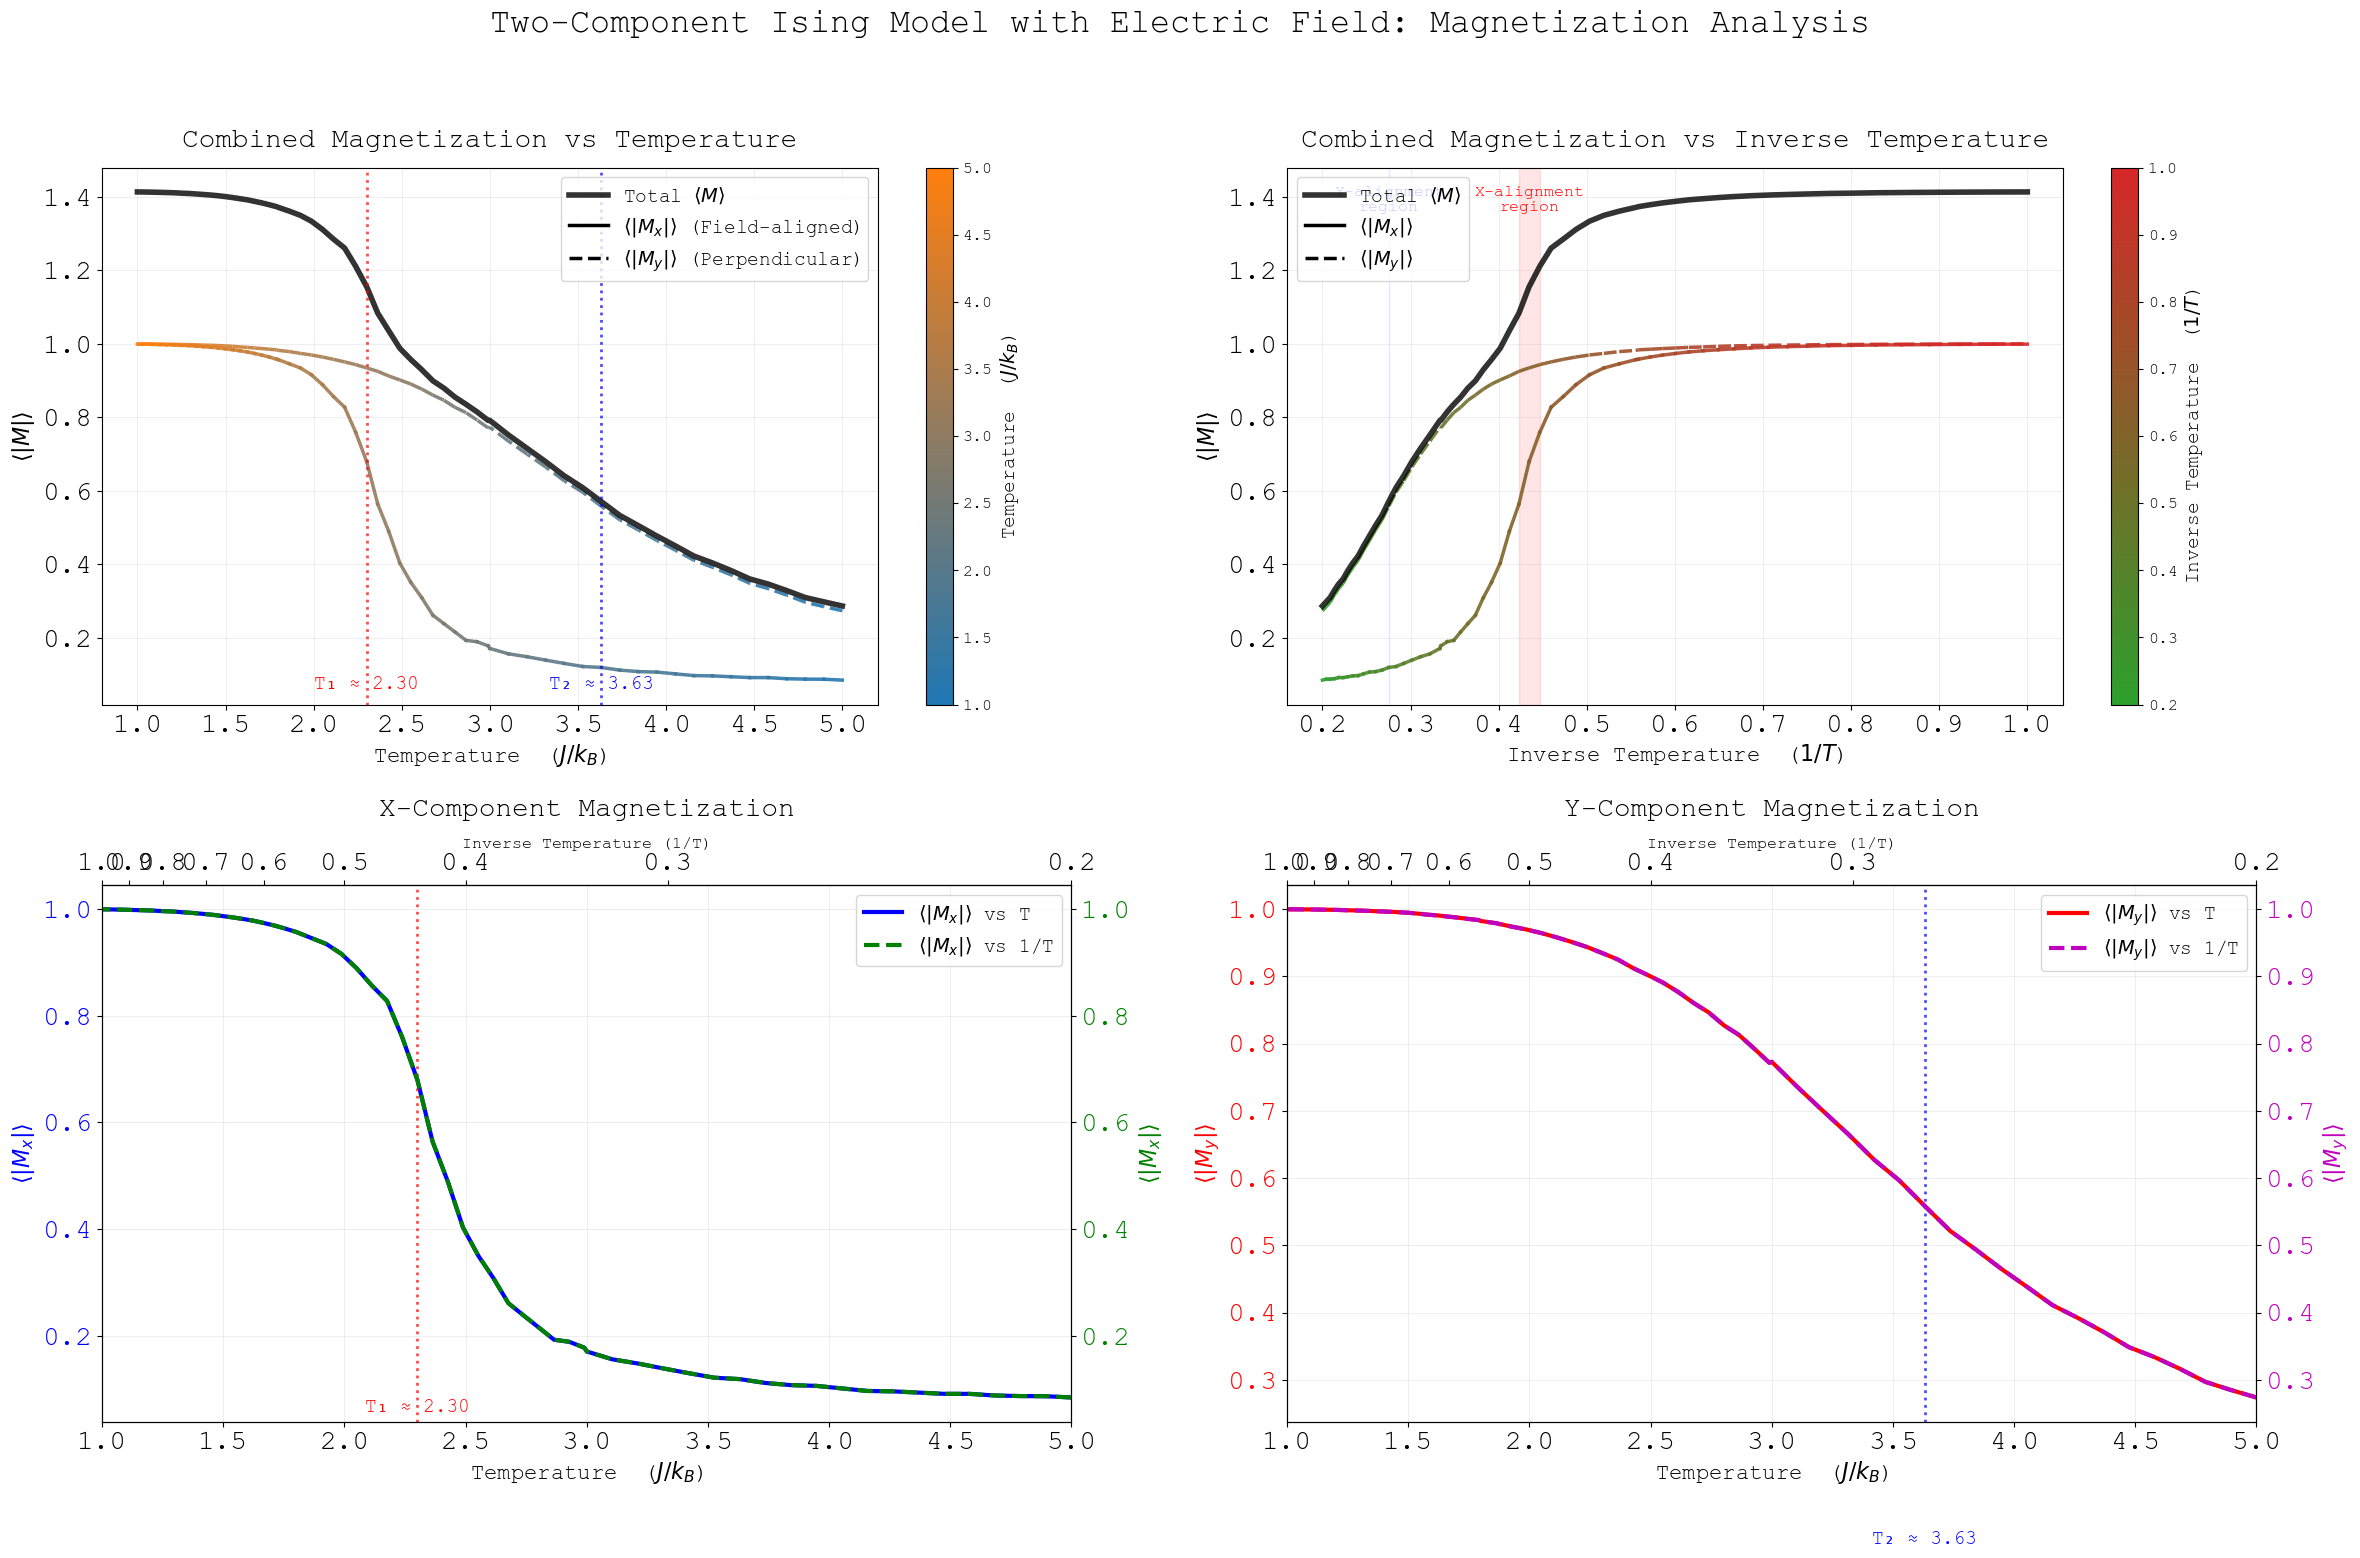

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Compute total magnetization
total_m = np.sqrt(np.array(avg_mx)**2 + np.array(avg_my)**2)

# Find transition regions (where derivatives are maximum)
dMx_dT = np.abs(np.gradient(avg_mx, temperatures))
dMy_dT = np.abs(np.gradient(avg_my, temperatures))

# Find approximate transition temperatures
T1_idx = np.argmax(dMx_dT)
T2_idx = np.argmax(dMy_dT)
T1 = temperatures[T1_idx]
T2 = temperatures[T2_idx]

# --- custom colour maps (same as before) --------------------------
cmap1 = LinearSegmentedColormap.from_list('phase_cmap',   ['#1f77b4', '#ff7f0e'])
cmap2 = LinearSegmentedColormap.from_list('inverse_cmap', ['#2ca02c', '#d62728'])

# Create 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(24, 16), dpi=100)
plt.subplots_adjust(wspace=0.25, hspace=0.3)

# Unpack the axes for easier reference
(ax1, ax2) = axs[0]  # Top row: combined plots
(ax3, ax4) = axs[1]  # Bottom row: individual component plots

# ===================================================================
#  Plot 1 (Top-left): Combined Mx, My and Total M vs Temperature
# ===================================================================
colors1 = cmap1(np.linspace(0, 1, len(temperatures)))

# Plot components with color gradient
for i in range(1, len(temperatures)):
    ax1.plot(temperatures[i-1:i+1], avg_mx[i-1:i+1],
             color=colors1[i], lw=2.5, alpha=0.9)
    ax1.plot(temperatures[i-1:i+1], avg_my[i-1:i+1],
             color=colors1[i], lw=2.5, ls='--', alpha=0.9)

# Plot total magnetization in bold
ax1.plot(temperatures, total_m, 'k-', lw=4, alpha=0.8, label=r'Total $\langle M \rangle$')

# Add transition markers
ax1.axvline(T1, color='r', linestyle=':', alpha=0.7, lw=2)
ax1.axvline(T2, color='b', linestyle=':', alpha=0.7, lw=2)
ax1.text(T1, 0.05, f'T₁ ≈ {T1:.2f}', color='r', fontsize=14, ha='center', va='bottom')
ax1.text(T2, 0.05, f'T₂ ≈ {T2:.2f}', color='b', fontsize=14, ha='center', va='bottom')

ax1.set_title('Combined Magnetization vs Temperature', fontsize=20, pad=15)
ax1.set_xlabel('Temperature  ($J/k_B$)', fontsize=16)
ax1.set_ylabel(r'$\langle|M|\rangle$', fontsize=16)
ax1.grid(True, alpha=0.2)

ax1.plot([], [], color='k', lw=2.5, label=r'$\langle |M_x| \rangle$ (Field-aligned)')
ax1.plot([], [], color='k', lw=2.5, ls='--', label=r'$\langle |M_y| \rangle$ (Perpendicular)')
ax1.legend(fontsize=14, loc='upper right')

# Colour bar for temperature
sm1 = plt.cm.ScalarMappable(cmap=cmap1,
            norm=plt.Normalize(vmin=min(temperatures), vmax=max(temperatures)))
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=ax1, orientation='vertical', label='Temperature  ($J/k_B$)')
cbar1.ax.tick_params(labelsize=12)
cbar1.set_label('Temperature  ($J/k_B$)', fontsize=14)

# ===================================================================
#  Plot 2 (Top-right): Combined Mx, My and Total M vs Inverse Temperature
# ===================================================================
invT = 1 / temperatures
colors2 = cmap2(np.linspace(0, 1, len(invT)))

# Plot components with color gradient
for i in range(1, len(invT)):
    ax2.plot(invT[i-1:i+1], avg_mx[i-1:i+1],
             color=colors2[i], lw=2.5, alpha=0.9)
    ax2.plot(invT[i-1:i+1], avg_my[i-1:i+1],
             color=colors2[i], lw=2.5, ls='--', alpha=0.9)

# Plot total magnetization in bold
ax2.plot(invT, total_m, 'k-', lw=4, alpha=0.8, label=r'Total $\langle M \rangle$')

# Highlight steep regions
steep_region1 = (invT > 1/(T1+0.1)) & (invT < 1/(T1-0.1))
steep_region2 = (invT > 1/(T2+0.1)) & (invT < 1/(T2-0.1))
ax2.fill_between(invT, 0, 1, where=steep_region1, color='r', alpha=0.1, transform=ax2.get_xaxis_transform())
ax2.fill_between(invT, 0, 1, where=steep_region2, color='b', alpha=0.1, transform=ax2.get_xaxis_transform())
ax2.text(1/T1, 0.92, 'X-alignment\nregion', color='r', fontsize=12, ha='center', transform=ax2.get_xaxis_transform())
ax2.text(1/T2, 0.92, 'Y-alignment\nregion', color='b', fontsize=12, ha='center', transform=ax2.get_xaxis_transform())

ax2.set_title('Combined Magnetization vs Inverse Temperature', fontsize=20, pad=15)
ax2.set_xlabel(r'Inverse Temperature  ($1/T$)', fontsize=16)
ax2.set_ylabel(r'$\langle|M|\rangle$', fontsize=16)
ax2.grid(True, alpha=0.2)

ax2.plot([], [], color='k', lw=2.5, label=r'$\langle |M_x| \rangle$')
ax2.plot([], [], color='k', lw=2.5, ls='--', label=r'$\langle |M_y| \rangle$')
ax2.legend(fontsize=14, loc='upper left')

# Colour bar for inverse temperature
sm2 = plt.cm.ScalarMappable(cmap=cmap2,
            norm=plt.Normalize(vmin=min(invT), vmax=max(invT)))
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', label=r'Inverse Temperature  ($1/T$)')
cbar2.ax.tick_params(labelsize=12)
cbar2.set_label(r'Inverse Temperature  ($1/T$)', fontsize=14)

# ===================================================================
#  Plot 3 (Bottom-left): Individual Mx vs Temperature and 1/T
# ===================================================================
# Left axis: Mx vs Temperature
ax3a = ax3
ax3a.plot(temperatures, avg_mx, 'b-', lw=3, label=r'$\langle |M_x| \rangle$ vs T')
ax3a.set_xlabel('Temperature  ($J/k_B$)', fontsize=16)
ax3a.set_ylabel(r'$\langle |M_x| \rangle$', fontsize=16, color='b')
ax3a.tick_params(axis='y', labelcolor='b')
ax3a.grid(True, alpha=0.2)

# Add transition marker
ax3a.axvline(T1, color='r', linestyle=':', alpha=0.7, lw=2)
ax3a.text(T1, 0.05, f'T₁ ≈ {T1:.2f}', color='r', fontsize=14, ha='center', va='bottom')

# Right axis: Mx vs Inverse Temperature
ax3b = ax3a.twinx()
ax3b.plot(temperatures, avg_mx, 'g--', lw=3, label=r'$\langle |M_x| \rangle$ vs 1/T')
ax3b.set_ylabel(r'$\langle |M_x| \rangle$', fontsize=16, color='g')
ax3b.tick_params(axis='y', labelcolor='g')

# Set x-axis to show both T and 1/T
ax3a.set_xlim(min(temperatures), max(temperatures))
secax_x3 = ax3a.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))
secax_x3.set_xlabel('Inverse Temperature (1/T)', fontsize=12)

ax3.set_title('X-Component Magnetization', fontsize=20, pad=15)

# Combine legends
lines, labels = ax3a.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3a.legend(lines + lines2, labels + labels2, fontsize=14, loc='best')

# ===================================================================
#  Plot 4 (Bottom-right): Individual My vs Temperature and 1/T
# ===================================================================
# Left axis: My vs Temperature
ax4a = ax4
ax4a.plot(temperatures, avg_my, 'r-', lw=3, label=r'$\langle |M_y| \rangle$ vs T')
ax4a.set_xlabel('Temperature  ($J/k_B$)', fontsize=16)
ax4a.set_ylabel(r'$\langle |M_y| \rangle$', fontsize=16, color='r')
ax4a.tick_params(axis='y', labelcolor='r')
ax4a.grid(True, alpha=0.2)

# Add transition marker
ax4a.axvline(T2, color='b', linestyle=':', alpha=0.7, lw=2)
ax4a.text(T2, 0.05, f'T₂ ≈ {T2:.2f}', color='b', fontsize=14, ha='center', va='bottom')

# Right axis: My vs Inverse Temperature
ax4b = ax4a.twinx()
ax4b.plot(temperatures, avg_my, 'm--', lw=3, label=r'$\langle |M_y| \rangle$ vs 1/T')
ax4b.set_ylabel(r'$\langle |M_y| \rangle$', fontsize=16, color='m')
ax4b.tick_params(axis='y', labelcolor='m')

# Set x-axis to show both T and 1/T
ax4a.set_xlim(min(temperatures), max(temperatures))
secax_x4 = ax4a.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))
secax_x4.set_xlabel('Inverse Temperature (1/T)', fontsize=12)

ax4.set_title('Y-Component Magnetization', fontsize=20, pad=15)

# Combine legends
lines, labels = ax4a.get_legend_handles_labels()
lines2, labels2 = ax4b.get_legend_handles_labels()
ax4a.legend(lines + lines2, labels + labels2, fontsize=14, loc='best')

# ===================================================================
# Add overall title
plt.suptitle('Two-Component Ising Model with Electric Field: Magnetization Analysis',
             fontsize=24, y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.show()

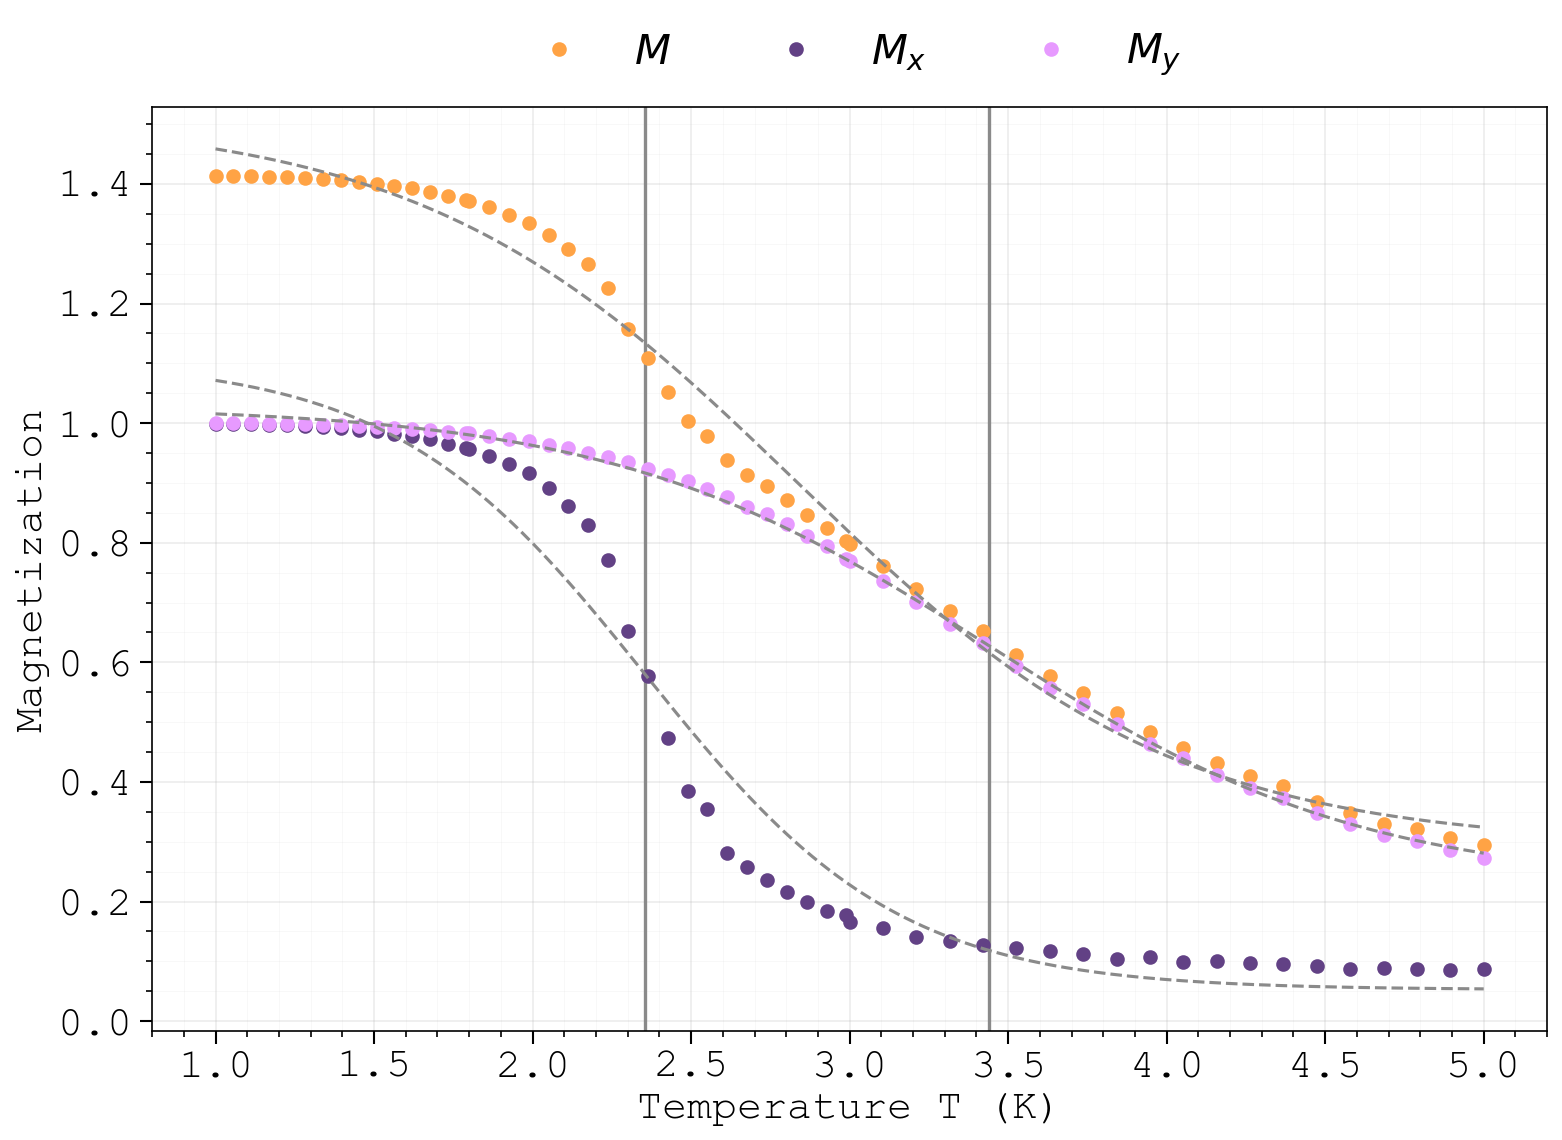

In [69]:
# Requires: arrays/lists `temperatures`, `avg_m`, `avg_mx`, `avg_my`

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# ---------- Fonts & export (like his) ----------
plt.rcParams.update({
    'font.family': ['Courier New', 'DejaVu Sans Mono', 'monospace'],
    'font.size': 20, 'axes.titlesize': 20, 'axes.labelsize': 20,
    'xtick.labelsize': 20, 'ytick.labelsize': 20, 'legend.fontsize': 20,
    'pdf.fonttype': 42, 'ps.fonttype': 42, 'savefig.dpi': 300, 'figure.dpi': 150,
})

# ---------- Grid & axes polish ----------
def polish_axes(ax):
    ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
    ax.minorticks_on()
    ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
    ax.set_axisbelow(True)
    for s in ("bottom","left","top","right"):
        ax.spines[s].set_linewidth(0.8)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', direction='out', length=6, width=1.0)
    ax.tick_params(which='minor', length=3, width=0.8)

# ---------- Sigmoid (logistic) fit: y = y2 + (y1 - y2)/(1 + exp(k*(x - x0)))
def fit_sigmoid(x_fit, y_fit, xs=None, n_x0=60, n_k=48):
    """
    Grid over x0 and k; solve least squares for y1,y2 each time.
    Returns xs, yhat, (y1, y2, k_best, x0_best).
    """
    x = np.asarray(x_fit, float); y = np.asarray(y_fit, float)
    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    order = np.argsort(x); x, y = x[order], y[order]
    if xs is None:
        xs = np.linspace(x.min(), x.max(), 600)

    xr = max(1e-12, x.max() - x.min())
    kmag = np.logspace(np.log10(0.1/xr), np.log10(10.0/xr), n_k//2)
    k_grid = np.concatenate([ -kmag[::-1], kmag ])
    x0_grid = np.linspace(x.min(), x.max(), n_x0)

    best = None
    for x0 in x0_grid:
        dx = x - x0
        for k in k_grid:
            z = np.clip(k*dx, -60.0, 60.0)
            phi = 1.0 / (1.0 + np.exp(z))                 # shape (n,)
            A = np.column_stack([phi, (1.0 - phi)])       # y = y1*phi + y2*(1-phi)
            coef, *_ = np.linalg.lstsq(A, y, rcond=None)  # [y1, y2]
            resid = A @ coef - y
            sse = float(resid.T @ resid)
            if (best is None) or (sse < best[0]):
                best = (sse, coef, k, x0)

    _, (y1, y2), k_best, x0_best = best
    z_pred = np.clip(k_best*(xs - x0_best), -60.0, 60.0)
    phi_pred = 1.0 / (1.0 + np.exp(z_pred))
    yhat = y1*phi_pred + y2*(1.0 - phi_pred)
    return xs, yhat, (y1, y2, k_best, x0_best)

# ---------- Data ----------
T   = np.asarray(temperatures, float)
M   = np.asarray(avg_m,  float)
Mx  = np.asarray(avg_mx, float)
My  = np.asarray(avg_my, float)

# sort by T
ordT = np.argsort(T)
T, M, Mx, My = T[ordT], M[ordT], Mx[ordT], My[ordT]

# ---------- Colors ----------
col_M  = "#ffa345"  # M (overall)
col_Mx = "#624185"  # Mx
col_My = "#e79aff"  # My
reg_color = "#8a8a8a"   # neutral grey for fits/lines
lw_line   = 1.5

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(12, 8))

# scatter points
ax.plot(T, M,  linestyle='None', marker='o', ms=6, color=col_M,  label=r'$M$')
ax.plot(T, Mx, linestyle='None', marker='o', ms=6, color=col_Mx, label=r'$M_x$')
ax.plot(T, My, linestyle='None', marker='o', ms=6, color=col_My, label=r'$M_y$')

# dashed sigmoid fits
xs = np.linspace(T.min(), T.max(), 600)
# M
xs_M,  ys_M,  _        = fit_sigmoid(T, M,  xs=xs)
ax.plot(xs_M, ys_M, color=reg_color, lw=lw_line, ls='--', zorder=2)
# Mx (also keep params for steepest point)
xs_Mx, ys_Mx, pars_Mx  = fit_sigmoid(T, Mx, xs=xs)
ax.plot(xs_Mx, ys_Mx, color=reg_color, lw=lw_line, ls='--', zorder=2)
# My (also keep params for steepest point)
xs_My, ys_My, pars_My  = fit_sigmoid(T, My, xs=xs)
ax.plot(xs_My, ys_My, color=reg_color, lw=lw_line, ls='--', zorder=2)

# vertical lines at steepest slope (x0 of the sigmoids) for Mx and My — no labels
x0_Mx = pars_Mx[3]
x0_My = pars_My[3]
ax.axvline(x0_Mx, color=reg_color, lw=1.6, zorder=1)
ax.axvline(x0_My, color=reg_color, lw=1.6, zorder=1)

# labels; no title
ax.set_xlabel("Temperature T (K)")
ax.set_ylabel("Magnetization")

polish_axes(ax)

# legend above (series only)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=3, frameon=False, borderaxespad=0.0)

plt.show()
fig.savefig("magnetization_vs_T_sigmoid_steepest.png", dpi=300, bbox_inches="tight", pad_inches=0.01)
# fig.savefig("magnetization_vs_T_sigmoid_steepest.svg", bbox_inches="tight")
# fig.savefig("magnetization_vs_T_sigmoid_steepest.pdf", bbox_inches="tight")


In [31]:
2.59--0.05

2.6399999999999997

#### Animating an Ising Sequence

Note that this requires a live kernel, and so will not show up on the blog or other static rendering:

In [37]:
# --- simulation parameters --------------------------------------
L = 100          # lattice size
T1 = 2.8         # Higher temp for x-alignment
T2 = 2.0         # Lower temp for y-alignment
h = 0.3          # Field strength in x-direction
n_frames = 100   # number of saved frames
# ---------------------------------------------------------------

# Create initial state
field_x = random_spin_field(L, L)
field_y = random_spin_field(L, L)
frames = [(field_x.copy(), field_y.copy())]

# First part: Thermalize at T1 (x-alignment)
for _ in range(n_frames//2):
    field_x, field_y = two_comp_step(field_x, field_y, beta=1/T1, J=1.0, h=h)
    frames.append((field_x.copy(), field_y.copy()))

# Second part: Cool to T2 (y-alignment)
for _ in range(n_frames//2):
    field_x, field_y = two_comp_step(field_x, field_y, beta=1/T2, J=1.0, h=h)
    frames.append((field_x.copy(), field_y.copy()))

display_two_component_sequence(frames)


TypeError: two_comp_step() got an unexpected keyword argument 'J'

# Cython - speed it up

In [21]:
pip install Cython

Note: you may need to restart the kernel to use updated packages.


In [22]:
%load_ext Cython

In [36]:
%%cython

cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_step(np.int64_t[:, :] field, float beta=0.4):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _cy_ising_update(field, n, m, beta, N, M)
    return np.array(field)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cy_ising_update(np.int64_t[:, :] field, int n, int m, float beta, int N, int M):
    cdef int total = 0
    # Directly compute indices for 4 orthogonal neighbors with periodic boundaries
    total += field[(n-1) % N, m]     # Up
    total += field[(n+1) % N, m]     # Down
    total += field[n, (m-1) % M]     # Left
    total += field[n, (m+1) % M]     # Right
    
    cdef float dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n, m] *= -1

Content of stderr:
In file included from /Users/linjiancheng/.cache/ipython/cython/_cython_magic_6f1ea97a9812e21600a1121f3c80d295bf17ff3953e4f7928d618e72bf35a151.c:1147:
In file included from /opt/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /opt/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /opt/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
1 warning generated.

#### Timing the result

In [37]:
field = random_spin_field(200, 200)
%timeit ising_step(field)
%timeit cy_ising_step(field)

144 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
864 μs ± 36.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Visualizing the result

(Note that the following code requires a live kernel, and will not display within a static rendering such as the blog post):

In [45]:
images = [random_spin_field(500, 500)]
for i in range(500):
    images.append(cy_ising_step(images[-1].copy(), beta=0.7))
display_ising_sequence(images);

interactive(children=(IntSlider(value=250, description='frame', max=500), Output()), _dom_classes=('widget-int…